## Deep Learning using Apache SystemML

From my notes: Apache SystemML is a flexible, scalable ML system enabling algorithm customization and automatic optimization. Unlike MLlib, it can be made to run on top of not just Apache Spark but other backends like Hadoop, Embedded-In-Memory etc. It has multiple execution models, inc. Spark ML context, Spark Batch, Hadoop batch, Standalone, JMLC. Though we will be using SparkMLContext in this project.

This project is the very basic, the hello world example for starting with SystemML on Spark backend parallel processing, but since it is a tool, an extremely powerful tool to be in Data Scientist's arsenal, I tried getting some hands-on in this too! :D

In [1]:
!pip install --upgrade https://github.com/niketanpansare/future_of_data/raw/master/systemml-1.1.0-SNAPSHOT-python.tar.gz
!ln -s -f ~/.local/lib/python2.7/site-packages/systemml/systemml-java/*.jar ~/data/libs/
!pip show systemml

    100% |████████████████████████████████| 10.3MB 2.4MB/s eta 0:00:01
Requirement not upgraded as not directly required: numpy>=1.8.2 in /usr/local/src/bluemix_jupyter_bundle.v105/notebook/lib/python2.7/site-packages (from systemml==1.1.0) (1.13.1)
Requirement not upgraded as not directly required: scipy>=0.15.1 in /usr/local/src/bluemix_jupyter_bundle.v105/notebook/lib/python2.7/site-packages (from systemml==1.1.0) (0.17.0)
Requirement not upgraded as not directly required: pandas in /usr/local/src/bluemix_jupyter_bundle.v105/notebook/lib/python2.7/site-packages (from systemml==1.1.0) (0.17.1)
Requirement not upgraded as not directly required: scikit-learn in /usr/local/src/bluemix_jupyter_bundle.v105/notebook/lib/python2.7/site-packages (from systemml==1.1.0) (0.17)
Requirement not upgraded as not directly required: Pillow>=2.0.0 in /usr/local/src/bluemix_jupyter_bundle.v105/notebook/lib/python2.7/site-packages (from systemml==1.1.0) (3.0.0)
Requirement not upgraded as not directly 

In [2]:
# SystemML of version 1.1 requires Spark of version 2 or above
sc.version   # I am running Python 2.7 with Spark 2.3 kernel

u'2.1.3'

In [3]:
from systemml import MLContext, dml
# Create ML context Object by passing spark context or spark session object
ml = MLContext(spark)
print(ml.info())

import sys, os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
plt.switch_backend('agg')

Archiver-Version: Plexus Archiver
Artifact-Id: systemml
Build-Jdk: 1.8.0_121
Build-Time: 2017-09-08 08:50:38 UTC
Built-By: asurve
Created-By: Apache Maven 3.3.9
Group-Id: org.apache.systemml
Main-Class: org.apache.sysml.api.DMLScript
Manifest-Version: 1.0
Minimum-Recommended-Spark-Version: 2.1.0
Version: 0.15.0



### Example 1: Hello World!

In [4]:
## Hello world example!

script = dml(""" 
print('Hello World'); 
""")
ml.execute(script)

Hello World
SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	0.




MLResults

### Example 2: Matrix Multiplication

In [5]:
## Generate random matrix, perform matrix multiplication and compute the sum of output

script = """
    X = rand(rows = $nr, cols = 1000, sparsity = 0.5)
    A = t(X) %*% X
    s = sum(A)
"""
prog = dml(script).input('$nr', 1e6).output('s')
s = ml.execute(prog).get('s')
print (s)

[Stage 0:>                                                         (0 + 0) / 59]
[Stage 0:>                                                        (0 + 10) / 59]
[Stage 0:>                                                        (1 + 11) / 59]
[Stage 0:==========>                                             (11 + 10) / 59]
[Stage 0:===================>                                    (21 + 10) / 59]
[Stage 0:=============================>                          (31 + 10) / 59]
[Stage 0:======================================>                 (41 + 10) / 59]
[Stage 0:=================================================>       (51 + 8) / 59]
SystemML Statistics:
Total execution time:		14.449 sec.
Number of executed Spark inst:	2.

                                                                                

62604001128.2


### Example 3: Visualization in SystemML

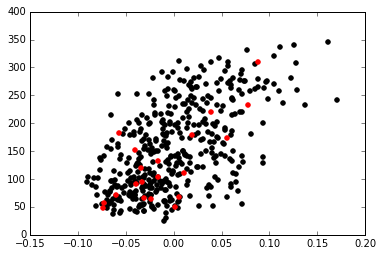

In [6]:
%matplotlib inline

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = np.matrix(diabetes.target[:-20]).T
diabetes_y_test = np.matrix(diabetes.target[-20:]).T

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

### Example 4: Linear Regression - Simple BGD model

In [11]:
script = """
    # add constant feature to X to model intercepts
    ones = matrix(1, rows=nrow(X), cols=1)
    X = cbind(X, ones)
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = (t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w - dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

In [12]:
model = dml(script).input(X=diabetes_X_train, y = diabetes_y_train).output('w').output('bias')
w, bias = ml.execute(model).get('w', 'bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.112 sec.
Number of executed Spark inst:	2.




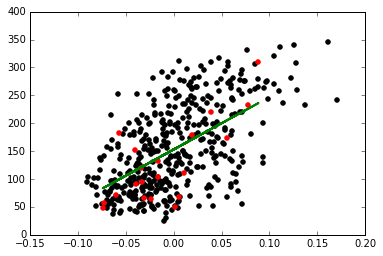

In [15]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')
plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='green', linestyle ='solid', linewidth = 2)


### Example 5: Invoking existing SystemML algorithm - LinearRegDS.dml

SystemML has inbuilt algorithms as well, which can be called using MLContextAPI. Most of the common algorithms can be found in './scripts/algorithms' folder

In [20]:
from systemml import dmlFromResource
model = dmlFromResource('scripts/algorithms/LinearRegDS.dml').input(X=diabetes_X_train, y=diabetes_y_train).input('$icpt', 1.0).output('beta_out')
w = ml.execute(model).get('beta_out')  # beta_out is the predefined output variable in the model 
w = w.toNumPy()
bias = w[1]

Computing the statistics...
Calling the Direct Solver...
BEGIN LINEAR REGRESSION SCRIPT
Reading X and Y...
END LINEAR REGRESSION SCRIPT
Writing the output matrix...
AVG_TOT_Y,153.36255924170615
STDEV_TOT_Y,77.21853383600028
AVG_RES_Y,3.633533705616816E-14
STDEV_RES_Y,63.038506337610244
DISPERSION,3973.853281276927
R2,0.3351312506863875
ADJUSTED_R2,0.33354822985468835
R2_NOBIAS,0.3351312506863875
ADJUSTED_R2_NOBIAS,0.33354822985468835
SystemML Statistics:
Total execution time:		0.002 sec.
Number of executed Spark inst:	2.




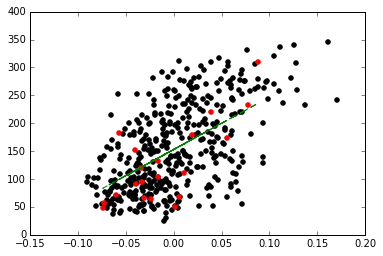

In [21]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w[0]*diabetes_X_test)+bias, color='green', linestyle ='dashed')

### Example 6 : Invoking Keras from SystemML 

In [25]:
!pip install mlxtend

    100% |████████████████████████████████| 1.3MB 9.4MB/s eta 0:00:01
    100% |████████████████████████████████| 5.5MB 4.0MB/s eta 0:00:01
    100% |████████████████████████████████| 12.6MB 1.7MB/s eta 0:00:01
    100% |████████████████████████████████| 102kB 19.4MB/s a 0:00:01
    100% |████████████████████████████████| 952kB 15.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for subprocess32 ... done
  Stored in directory: /gpfs/fs01/user/sec9-e7fbc73d54603b-96160961875a/.cache/pip/wheels/c0/08/48/bb468e57d688ea6fa40a450d88d7d9f5fb3c955510077da743
Successfully built subprocess32
tensorflow 1.2.1 has requirement bleach==1.5.0, but you'll have bleach 2.0.0 which is incompatible.
tensorflow 1.2.1 has requirement html5lib==0.9999999, but you'll have html5lib 0.999999999 which is incompatible.


In [26]:
from mlxtend.data import mnist_data
import numpy as np
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout,Flatten
from keras import backend as K
from keras.models import Model

X, y = mnist_data()
X, y = shuffle(X, y)

# Split the data into training and test
n_samples = len(X)
X_train = X[:int(.9 * n_samples)]
y_train = y[:int(.9 * n_samples)]
X_test = X[int(.9 * n_samples):]
y_test = y[int(.9 * n_samples):]

input_shape = (1,28,28) if K.image_data_format() == 'channels_first' else (28,28, 1)
keras_model = Sequential()
keras_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same'))
keras_model.add(MaxPooling2D(pool_size=(2, 2)))
keras_model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
keras_model.add(MaxPooling2D(pool_size=(2, 2)))
keras_model.add(Flatten())
keras_model.add(Dense(512, activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(10, activation='softmax'))

# Scale the input features
scale = 0.004
X_train = X_train*scale
X_test = X_test*scale


# Now comes the magical part!! 
from systemml.mllearn import Keras2DML
sysml_model = Keras2DML(spark, keras_model, input_shape=(1,28,28), weights='weights_dir')
sysml_model.setConfigProperty('sysml.native.blas', 'openblas')
sysml_model.setConfigProperty('sysml.native.blas.directory', os.path.join(os.getcwd(),'OpenBLAS-0.2.20/'))
# sysml_model.setGPU(True).setForceGPU(True)
sysml_model.summary()
sysml_model.fit(X_train, y_train)

Using TensorFlow backend.


Loading the model from weights_dir...
SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	0.


+-------------------+---------------+--------------+------------+---------+-------------------+--------------------+
|               Name|           Type|        Output|      Weight|     Bias|                Top|              Bottom|
+-------------------+---------------+--------------+------------+---------+-------------------+--------------------+
|     conv2d_1_input|           Data| (, 1, 28, 28)|            |         |     conv2d_1_input|                    |
|           conv2d_1|    Convolution|(, 32, 28, 28)|   [32 X 25]| [32 X 1]|           conv2d_1|      conv2d_1_input|
|conv2d_1_activation|           ReLU|(, 32, 28, 28)|            |         |conv2d_1_activation|            conv2d_1|
|    max_pooling2d_1|        Pooling|(, 32, 14, 14)|            |         |    max_pooling2d_1| conv2d_1_activation|
|           conv2d_2|    Convolution|(, 64, 14, 14)|

Caffe2DML



Ref : http://apache.github.io/systemml/deep-learning